# **Tentang Dataset**
Dataset "Stunting Toddler (Balita) Detection" ini kumpulan data berdasarkan rumus z-score penentuan stunting menurut WHO (World Health Organization), yang berfokus pada deteksi stunting pada balita (bayi dibawah lima tahun). Dataset ini terdiri dari 121.000 baris data, yang merinci informasi mengenai umur, jenis kelamin, tinggi badan, dan status gizi balita. Dataset ini bertujuan untuk membantu peneliti, ahli gizi, dan pembuat kebijakan dalam memahami dan mengatasi masalah stunting pada anak-anak di bawah lima tahun.

**Rincian Kolom Dataset:**

- **Umur (Bulan)**: Mengindikasikan usia balita dalam bulan. Rentang usia ini penting untuk menentukan fase pertumbuhan anak dan membandingkannya dengan standar pertumbuhan yang sehat. **(Umur 0 sampai 60 bulan)**

- **Jenis Kelamin**: Terdapat dua kategori dalam kolom ini, 'laki-laki' (male) dan 'perempuan' (female). Jenis kelamin merupakan faktor penting dalam analisis pola pertumbuhan dan risiko stunting.

- **Tinggi Badan**: Dicatat dalam centimeter, tinggi badan adalah indikator utama untuk menilai pertumbuhan fisik balita. Data ini memungkinkan peneliti untuk menentukan apakah pertumbuhan anak sesuai dengan standar usianya.

- **Status Gizi**: Kolom ini dikategorikan menjadi 4 status - 'severely stunting', 'stunting', 'normal', dan 'tinggi'. 'Severely stunting' menunjukkan kondisi sangat serius (<-3 SD), 'stunting' menunjukkan kondisi stunting (-3 SD sd <-2 SD), 'normal' mengindikasikan status gizi yang sehat (-2 SD sd +3 SD), dan 'tinggi' (height) menunjukkan pertumbuhan di atas rata-rata (>+3 SD). Kategori ini membantu dalam identifikasi cepat dan intervensi bagi anak-anak yang berisiko atau mengalami masalah pertumbuhan.

# **Import Library**

In [ ]:
from google.colab import userdata
import os
import random
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# **Dataset**

**Tahap ini adalah mengambil dataset dari repository github. Saya meletakkan dataset di repository github agar mudah ketika dilakukan penjalanan ulang setiap cell pada notebook**

In [ ]:
url = 'https://raw.githubusercontent.com/agummds/Predictive-Analytics/master/Dataset/data_balita.csv'

df = pd.read_csv(url)
df.head(20)

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted
5,0,laki-laki,44.257719,stunted
6,0,laki-laki,59.572523,tinggi
7,0,laki-laki,42.701796,severely stunted
8,0,laki-laki,45.251779,stunted
9,0,laki-laki,57.201961,tinggi


In [ ]:
df.tail()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
120994,60,perempuan,100.6,normal
120995,60,perempuan,98.3,stunted
120996,60,perempuan,121.3,normal
120997,60,perempuan,112.2,normal
120998,60,perempuan,109.8,normal


**Dapat dilihat bahwa jumlah dataset terdiri dari 120998 data. Hal ini dapat dibilang cukup banyak untuk dilakukan pemrosesan data untuk predictive analytics**

# **Exploratory Data Analysis (EDA)**

## a. Cek struktur dan informasi awal data

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


**Dapat dilihat bahwa Jumlah total data: 120.999 baris dan 4 kolom. Semua kolom tidak memiliki nilai null, artinya data bersih dari missing values.**

- 25% balita berumur ≤ 15 bulan dan tinggi ≤ 77 cm → menggambarkan fase awal pertumbuhan.

- 50% balita (median) berumur 30 bulan dan tinggi 89.8 cm → representasi balita umum dalam dataset.

- 75% balita berumur ≤ 45 bulan dan tinggi ≤ 101.2 cm.

**Statistik Tinggi Badan (dalam cm)**
- Rata-rata: 88.66 cm.
- Rentang: dari 40 cm hingga 128 cm.
- Nilai min (40 cm) kemungkinan adalah bayi baru lahir, dan max (128 cm) bisa jadi outlier jika dibandingkan dengan rata-rata tinggi balita umur 5 tahun (~110 cm).


## b. Distribusi Status Gizi

<Axes: xlabel='Status Gizi', ylabel='count'>

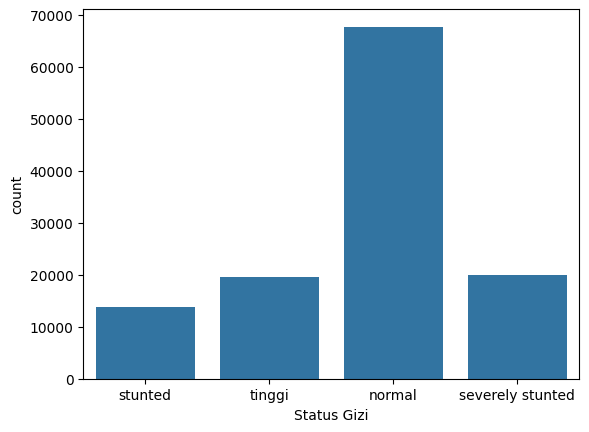

In [ ]:
sns.countplot(data=df, x='Status Gizi')

**Insight dari Visualisasi**
- Kategori Normal Mendominasi
- Balita dengan status gizi normal mencapai sekitar 68.000 kasus. Ini berarti lebih dari setengah populasi memiliki kondisi gizi yang baik.
Masalah Stunting Masih Signifikan
- Gabungan kategori stunted dan severely stunted mencapai sekitar 30.000 kasus Sekitar 25% data menunjukkan masalah gizi kronis yang perlu perhatian khusus.
Kategori Tinggi Juga Menonjol
- Sekitar 20.000 balita masuk kategori tinggi, hampir sebanding dengan jumlah kasus stunting.

## d. Cek rata-rata tinggi & umur per kategori status gizi.

In [ ]:
df.groupby('Status Gizi')[['Umur (bulan)', 'Tinggi Badan (cm)']].describe()

Umur (bulan)                                               \
                        count       mean        std  min   25%   50%   75%   
Status Gizi                                                                  
normal                67755.0  32.607601  17.007331  0.0  19.0  34.0  47.0   
severely stunted      19869.0  26.290956  17.582342  0.0  11.0  24.0  41.0   
stunted               13815.0  32.763807  17.062236  0.0  19.0  34.0  48.0   
tinggi                19560.0  23.858129  17.572063  0.0   8.0  21.0  37.0   

                       Tinggi Badan (cm)                                   \
                   max             count       mean        std        min   
Status Gizi                                                                 
normal            60.0           67755.0  92.702689  15.676267  45.433571   
severely stunted  60.0           19869.0  73.176224  13.645497  40.010437   
stunted           60.0           13815.0  82.208722  12.436462  43.623654   
tinggi            60.0           19560.0  94.912898  18.259081  54.716373   

                                              
                     25%   50%    75%    max  
Status Gizi                                   
normal            82.800  94.9  104.2  123.9  
severely stunted  63.200  75.1   84.6   95.9  
stunted           74.900  84.9   92.1  100.7  
tinggi            79.975  96.0  110.0  128.0

**Dari data di tabel dapat dilihat bahwa:**
- Anak-anak dengan status "severely stunted" dan "stunted" cenderung lebih pendek dari usia sebayanya:
- Rata-rata tinggi "severely stunted" adalah 73.18 cm, yang jauh lebih rendah dibandingkan "normal" (92.70 cm).

**Ini menandakan masalah pertumbuhan kronis.**
- Anak-anak dengan status "tinggi" memiliki tinggi rata-rata tertinggi (94.91 cm) meskipun usia mereka justru paling kecil (23.86 bulan):
- Ini bisa menunjukkan bahwa anak-anak dengan pertumbuhan cepat cenderung sudah terlihat sejak dini.

**Perbedaan umur dan tinggi badan:**
- Meskipun stunted dan normal memiliki umur rata-rata hampir sama (32 bulan), tinggi badan mereka berbeda signifikan (10 cm selisih).

# **Univariate Analysis**

## 1. Umur (bulan) — numerik

Text(0.5, 1.0, 'Distribusi Umur')

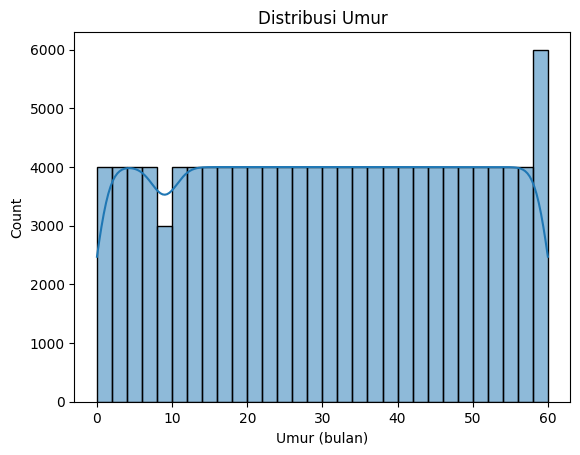

In [ ]:
sns.histplot(df['Umur (bulan)'], bins=30, kde=True)
plt.title('Distribusi Umur')

**Insight dari Visualisasi**
- Distribusi Umur Merata
Mayoritas balita tersebar merata dalam rentang usia 0–59 bulan.
Dataset cukup representatif terhadap semua kelompok umur.
Lonjakan pada Usia 60 Bulan
- Terdapat puncak jumlah data pada usia 60 bulan.
Kemungkinan disebabkan pencatatan massal pada usia maksimum balita.
Penurunan pada Usia 9–11 Bulan
- Penurunan kecil pada rentang ini bisa menunjukkan ketidakseimbangan data atau bias dalam pengumpulan informasi.

## 2. Tinggi Badan (cm) — numerik

Text(0.5, 1.0, 'Boxplot Tinggi Badan')

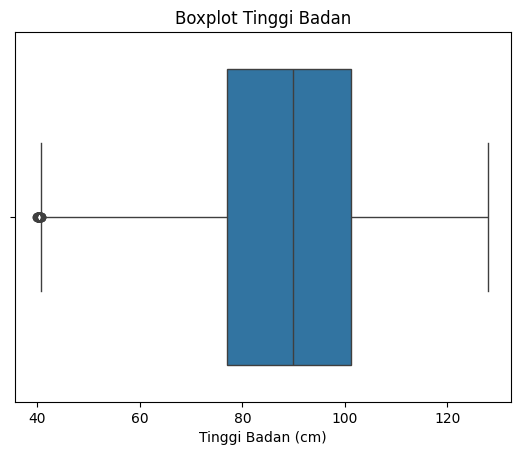

In [ ]:
sns.boxplot(x=df['Tinggi Badan (cm)'])
plt.title('Boxplot Tinggi Badan')

**Insight dari Visualisasi**

- Tinggi badan berkisar antara 40 cm hingga 130 cm. Mewakili rentang usia balita yang luas.
- Median Tinggi Badan Sekitar 95–100 cm
- Nilai tengah distribusi berada di kisaran tinggi anak usia 2–4 tahun.
Outlier pada Nilai Rendah
- Terdapat outlier sekitar 40 cm yang bisa mewakili bayi baru lahir atau potensi data error.
- Distribusi Simetris
- Tampilan boxplot menunjukkan distribusi tinggi badan yang relatif seimbang.

## 3. Jenis Kelamin — kategorikal

Text(0.5, 1.0, 'Distribusi Jenis Kelamin')

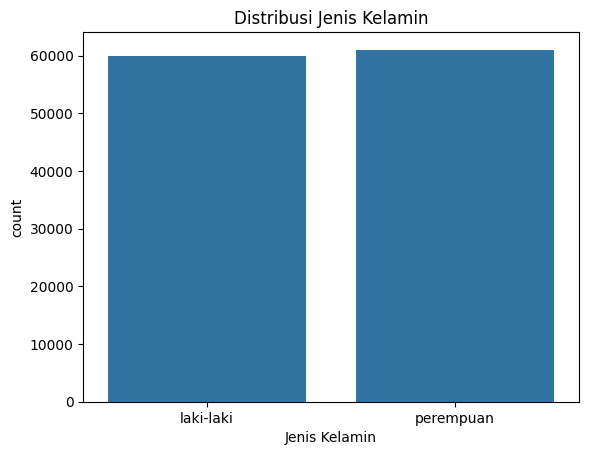

In [ ]:
sns.countplot(x='Jenis Kelamin', data=df)
plt.title('Distribusi Jenis Kelamin')

**Distribusi Seimbang**

- Balita laki-laki berjumlah sekitar 60.000.
- Balita perempuan berjumlah sekitar 61.000.
- Tidak ada ketimpangan besar antara keduanya.

**Data Representatif**
- Keseimbangan ini penting untuk menjaga fairness model dalam prediksi.
- Tidak ada indikasi bias gender dalam distribusi data.

# Multivariate Analysis EDA

## 1. Umur vs Tinggi Badan (scatter plot)

Text(0.5, 1.0, 'Umur vs Tinggi Badan per Status Gizi')

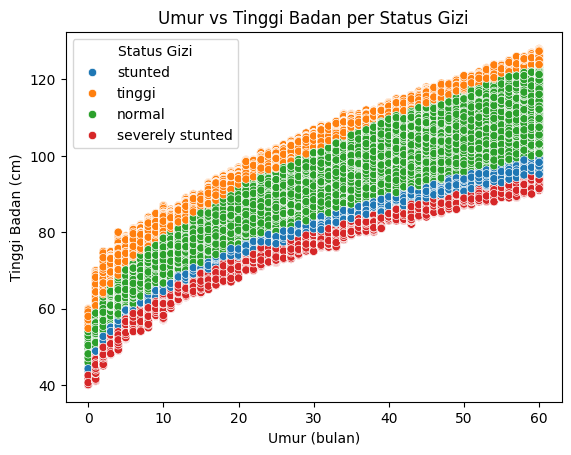

In [ ]:
sns.scatterplot(data=df, x='Umur (bulan)', y='Tinggi Badan (cm)', hue='Status Gizi')
plt.title('Umur vs Tinggi Badan per Status Gizi')

**Dari gambar dapat dilihat bahwa:**
- Tinggi Badan Meningkat Seiring Bertambahnya Umur. Semua kategori menunjukkan pola pertumbuhan yang positif sesuai usia balita.
Pemisahan Status Gizi Jelas
- Kategori seperti tinggi, normal, stunted, dan severely stunted membentuk pola sendiri-sendiri yang tidak saling tumpang tindih secara signifikan. Visual ini mendukung keandalan label untuk klasifikasi.

**Tinggi vs Severely Stunted**
Anak dengan status tinggi memiliki tinggi badan lebih dominan sepanjang usia.
Severely stunted menunjukkan pertumbuhan yang paling rendah secara konsisten.
Distribusi Konsisten hingga 60 Bulan. Tidak terlihat anomali atau stagnasi pada distribusi tinggi badan, yang menandakan dataset cukup baik.

## 2. Jenis Kelamin vs Status Gizi (countplot with hue)

Text(0.5, 1.0, 'Distribusi Status Gizi per Jenis Kelamin')

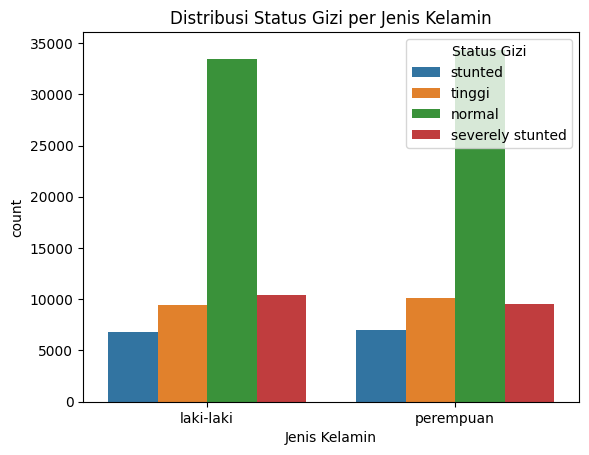

In [ ]:
sns.countplot(data=df, x='Jenis Kelamin', hue='Status Gizi')
plt.title('Distribusi Status Gizi per Jenis Kelamin')

**Insight dari Visualisasi**
- Status Gizi Normal Mendominasi. Baik laki-laki maupun perempuan mayoritas masuk dalam kategori normal. Laki-laki sedikit lebih unggul dalam jumlah anak dengan gizi normal.
- Distribusi Cenderung Seimbang. Semua kategori status gizi memiliki jumlah yang relatif seimbang antara jenis kelamin.
Tidak ditemukan ketimpangan signifikan antara laki-laki dan perempuan.
Kategori Tinggi Sedikit Lebih Banyak pada Perempuan
- Anak perempuan sedikit lebih banyak berada dalam kategori tinggi dibanding laki-laki, meski perbedaannya tipis.

## 3. Boxplot Tinggi Badan berdasarkan Status Gizi

Text(0.5, 1.0, 'Tinggi Badan per Kategori Status Gizi')

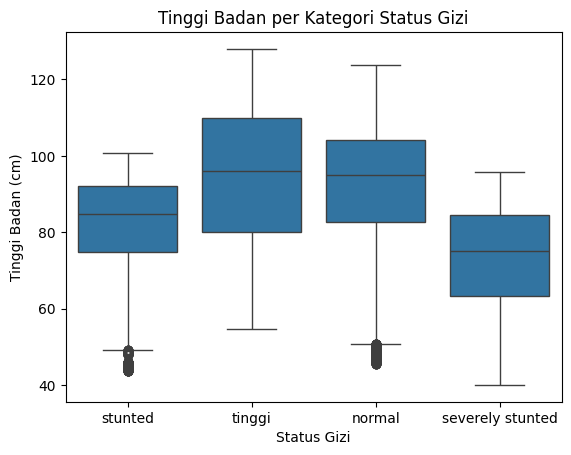

In [ ]:
sns.boxplot(data=df, x='Status Gizi', y='Tinggi Badan (cm)')
plt.title('Tinggi Badan per Kategori Status Gizi')

**Tinggi Badan Berkorelasi dengan Status Gizi**

- Anak dengan status gizi tinggi memiliki tinggi badan paling tinggi secara median maupun sebaran. Sebaliknya, anak dengan status severely stunted memiliki tinggi paling rendah.
- Sebaran Tinggi Lebih Luas di Kategori Normal dan Tinggi. Menunjukkan variasi tinggi badan yang lebih besar pada anak-anak yang tergolong sehat atau sangat sehat.
- Outlier di Setiap Kategori.
Adanya nilai ekstrem (outlier) di semua kategori menunjukkan bahwa meskipun pola umum terlihat jelas, ada kasus khusus yang perlu diperhatikan lebih lanjut.

## 4. Pairplot (semua kombinasi numerik)

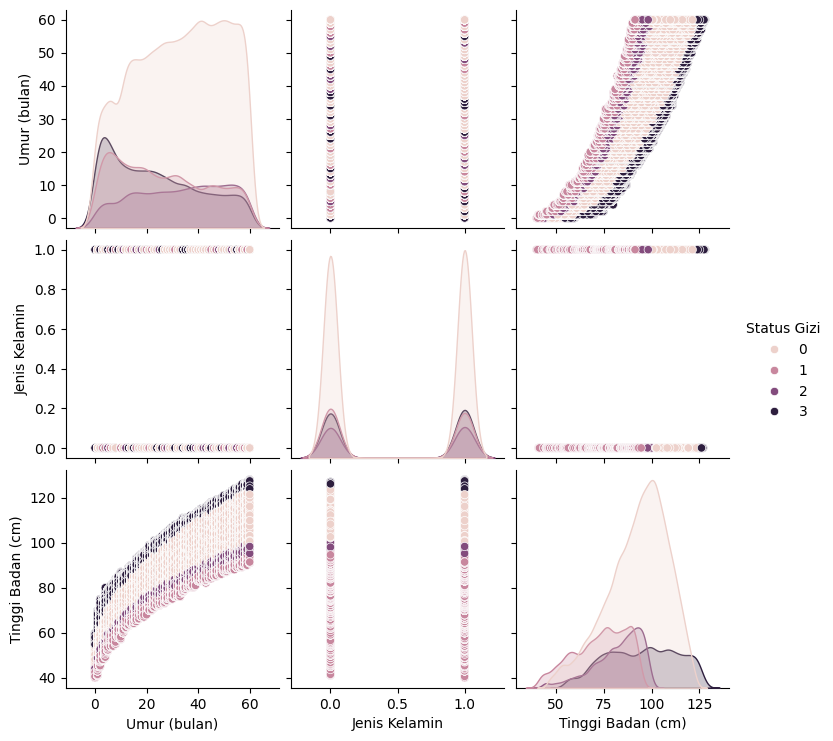

In [ ]:
df_encoded = df.copy()
df_encoded['Jenis Kelamin'] = LabelEncoder().fit_transform(df_encoded['Jenis Kelamin'])
df_encoded['Status Gizi'] = LabelEncoder().fit_transform(df_encoded['Status Gizi'])

sns.pairplot(df_encoded, hue='Status Gizi')

# Data Preparation

## Encode kolom kategorikal dan cek korelasi

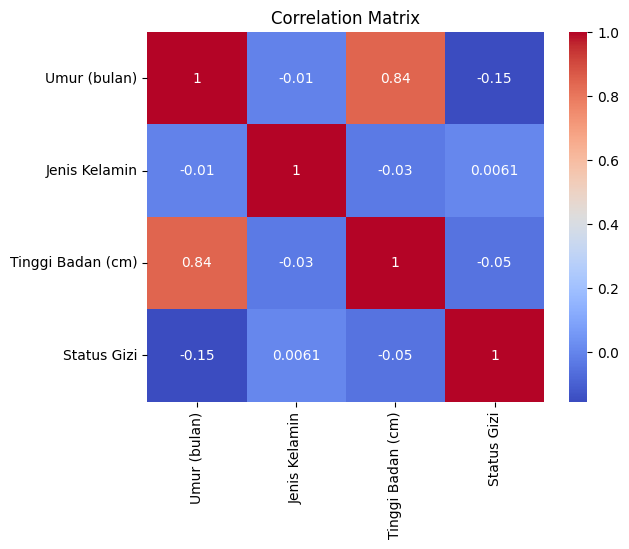

In [ ]:
df_encoded = df.copy()
le_gender = LabelEncoder()
le_status = LabelEncoder()

df_encoded['Jenis Kelamin'] = le_gender.fit_transform(df_encoded['Jenis Kelamin'])
df_encoded['Status Gizi'] = le_status.fit_transform(df_encoded['Status Gizi'])

# Sekarang bisa cek korelasi
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

**Dari gambar dapat dilihat bahwa:**
- Korelasi tertinggi adalah antara Umur dan Tinggi Badan (0.84): Ini sangat logis karena pertumbuhan fisik (tinggi badan) memang berkaitan erat dengan usia.
- Status Gizi punya korelasi lemah dengan semua fitur: Menandakan bahwa klasifikasi status gizi tidak linear terhadap umur maupun tinggi badan. Bisa jadi distribusinya non-linear atau kompleks, cocok digunakan model klasifikasi seperti Decision Tree, Random Forest, SVM, atau Neural Network.
- Jenis kelamin hampir tidak berpengaruh ke status gizi secara statistik: Tapi tetap bisa dicoba dimasukkan ke model, karena bisa saja memiliki pengaruh secara tidak langsung.

In [ ]:
df_encoded.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,44.591973,2
1,0,0,56.705203,3
2,0,0,46.863358,0
3,0,0,47.508026,0
4,0,0,42.743494,1


In [ ]:
df_encoded.tail()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
120994,60,1,100.6,0
120995,60,1,98.3,2
120996,60,1,121.3,0
120997,60,1,112.2,0
120998,60,1,109.8,0


## Pembagian Dataset

In [ ]:
X = df[['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']]
y = df['Status Gizi']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

##  Model Training dan Evaluasi

## a. Decision Tree Classifier
Decision Tree Classifier adalah salah satu algoritma machine learning untuk tugas klasifikasi yang bekerja dengan cara membagi data ke dalam cabang-cabang berdasarkan fitur-fitur tertentu hingga mencapai keputusan akhir (kelas)

In [ ]:
# Create a LabelEncoder object
le_gender = LabelEncoder()

# Encode fitur 'Jenis Kelamin'
X_train['Jenis Kelamin'] = le_gender.fit_transform(X_train['Jenis Kelamin'])
X_test['Jenis Kelamin'] = le_gender.transform(X_test['Jenis Kelamin'])

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Decode y_test ke label string
y_test_labels = le_status.inverse_transform(y_test)

# Evaluation
print("Decision Tree Classifier:")
print(classification_report(y_test_labels, y_pred_dt))


Decision Tree Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13551
           1       1.00      1.00      1.00      3974
           2       1.00      1.00      1.00      2763
           3       1.00      1.00      1.00      3912

    accuracy                           1.00     24200
   macro avg       1.00      1.00      1.00     24200
weighted avg       1.00      1.00      1.00     24200



- Precision: Akurasi prediksi positif untuk tiap kelas. Misalnya, untuk kelas 0, dari semua yang diprediksi sebagai 0, semuanya benar.

- Recall: Kemampuan model dalam menemukan semua contoh yang benar-benar termasuk dalam kelas tersebut.

- F1-score: Rata-rata harmonik dari precision dan recall.

- Support: Jumlah data aktual di setiap kelas.

Model berhasil memprediksi semua data dengan sempurna (nilai semua metrik = 1.00).

Tapi ini juga perlu diwaspadai karena hasil terlalu sempurna bisa jadi indikasi overfitting, apalagi jika diuji di data latih, bukan data uji/validasi.

## b. Random Forest Classifier

Random Forest Classifier adalah algoritma machine learning berbasis ensemble learning yang menggabungkan banyak Decision Tree untuk meningkatkan akurasi dan mengurangi overfitting.

In [ ]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Decode y_test ke label string
y_test_labels = le_status.inverse_transform(y_test)

# Evaluation
print("Random Forest Classifier:")
print(classification_report(y_test_labels, y_pred_rf))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13551
           1       1.00      1.00      1.00      3974
           2       1.00      1.00      1.00      2763
           3       1.00      1.00      1.00      3912

    accuracy                           1.00     24200
   macro avg       1.00      1.00      1.00     24200
weighted avg       1.00      1.00      1.00     24200



- Performa model sangat sempurna pada data yang diuji (precision, recall, f1-score = 1.00).

- Hasil ini menunjukkan tidak ada kesalahan klasifikasi sama sekali.

- Tapi, seperti halnya hasil Decision Tree kamu sebelumnya, ini juga perlu dicurigai sebagai tanda overfitting, terutama jika evaluasi dilakukan pada data latih, bukan data uji/validasi.



## c. XGBoost Classifier
XGBoost (Extreme Gradient Boosting) adalah algoritma ensemble berbasis gradient boosting yang sangat cepat dan powerful, sering digunakan untuk kompetisi machine learning karena performanya yang sangat baik.

In [ ]:
# Create a LabelEncoder for the 'Status Gizi' column
le_status = LabelEncoder()

# Apply Label Encoding to the 'Status Gizi' column in the original DataFrame before splitting
df['Status Gizi'] = le_status.fit_transform(df['Status Gizi'])

# Create a LabelEncoder object for 'Jenis Kelamin'
le_gender = LabelEncoder()

# Fit the encoder on the training data and transform both train and test data
X_train['Jenis Kelamin'] = le_gender.fit_transform(X_train['Jenis Kelamin'])
X_test['Jenis Kelamin'] = le_gender.transform(X_test['Jenis Kelamin'])

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Train model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13551
           1       0.99      0.99      0.99      3974
           2       0.97      0.97      0.97      2763
           3       0.99      1.00      0.99      3912

    accuracy                           0.99     24200
   macro avg       0.99      0.99      0.99     24200
weighted avg       0.99      0.99      0.99     24200



- Performa sangat bagus dengan akurasi 99%.

- Sedikit kesalahan mulai muncul dibandingkan Decision Tree dan Random Forest sebelumnya yang 100%.

- Namun hasil ini lebih realistis dan mengindikasikan model ini mungkin lebih generalizable (tidak overfit).

- Nilai f1-score kelas 2 sedikit lebih rendah (0.97), mungkin karena data tersebut lebih sulit diklasifikasikan atau lebih sedikit jumlahnya.

# Evaluasi Model: Penerapan Metrik Kinerja & Visualisasi Model

 ## Langkah 1: Evaluasi dengan Metrik Kinerja

<ipython-input-41-a8d13ffb9dd0>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='coolwarm')


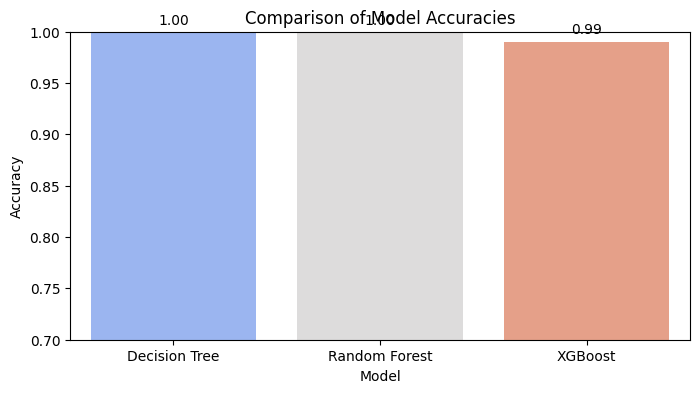

In [ ]:
# Mengumpulkan akurasi dari setiap model
# Create a dictionary to store the models and their predictions
models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

# Get predictions for each model
predictions = {name: model.predict(X_test) for name, model in models.items()}

# Calculate accuracies
accuracies = [accuracy_score(y_test, predictions[name]) for name in models]
model_names = list(models.keys())

# Membuat DataFrame untuk akurasi model
accuracy_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# Visualisasi akurasi menggunakan seaborn
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='coolwarm')
ax.set_ylim(0.7, 1.0)  # Set limit y-axis untuk memudahkan perbandingan
ax.set_title('Comparison of Model Accuracies')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')

# Menambahkan teks akurasi pada setiap batang
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()

In [ ]:
print(accuracy_df)

           Model  Accuracy
0  Decision Tree  0.999174
1  Random Forest  0.999215
2        XGBoost  0.990455


## Langkah 2: Visualisasi Akurasi Model

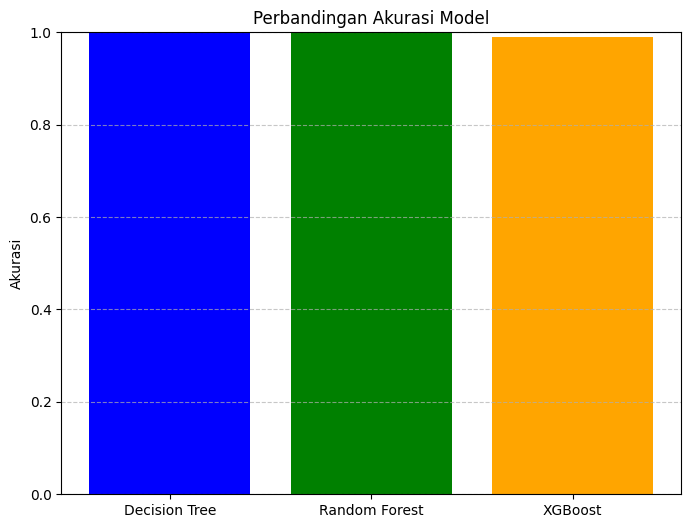

In [ ]:
# Plot akurasi model
plt.figure(figsize=(8, 6))
# Replace model_scores with accuracy_df
plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color=['blue', 'green', 'orange'])
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Akurasi")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: >

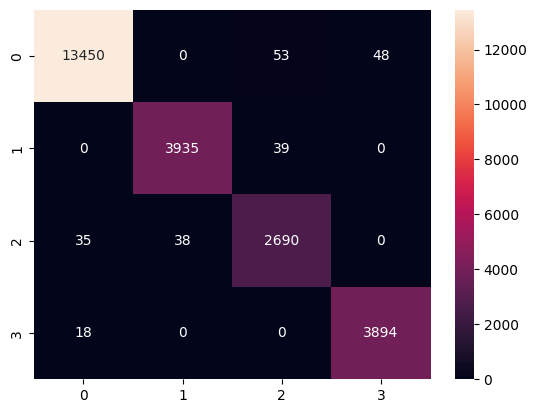

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test_labels, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d')